# Generate X and y for CNN model

In [1]:
# run only once.
import os
os.chdir("..")
!pwd
!pyenv version
%load_ext autoreload
%autoreload 2

/Users/loicmorel/code/projetcs/crypto_assistant
crypto_assistant (set by PYENV_VERSION environment variable)


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField
from mpl_toolkits.axes_grid1 import ImageGrid
from datetime import datetime
from datetime import timezone
from app.indicators import find_swings
from app.indicators import classify_swings

In [32]:
# run me...
def generate_gaf(data):
    gadf = GramianAngularField(method='difference', image_size=data.shape[0])
    img = gadf.fit_transform(pd.DataFrame(data).T)[0]
    return img

def generate_gaf_images_from_ohlc(data, params, idx):
    ## identify target
    target = False
    for t in params['target']:
        if data[:idx][t].iloc[-1]:
            target = t
    if not target:
        return np.nan

    ## slicing data from the bottom of the df (reverse the time) 
    ## to the top from the index provided by the lambda function
    data_slice = data[:idx][['o_ts', params['focus']]]
    img = []
    ret = params.copy()
    ret['target'] = target
    
    ## for 4x frequency to compose the gaf matrix
    for freq in params['freq']:
        data_ = data_slice.groupby(pd.Grouper(key='o_ts', freq=freq)).mean().reset_index()
        data_ = data_.dropna()
        data__ = data_[::-1].reset_index().drop(columns='index')
        data___ = data__[:params['depth']]
        if data___.shape[0] < params['depth']:
            return np.nan
        ret[f'start_time_{freq}'] = data___['o_ts'].iloc[0]
        ret[f'end_time_{freq}'] = data___['o_ts'].iloc[-1]
        img.append(generate_gaf(data___[params['focus']]))
    ret['img'] = np.array(img)
    return (ret)

def plot_gaf_image_matrix(img_np, target):
    image_matrix: tuple =(2, 2)
    fig = plt.figure(figsize=[img * 4 for img in image_matrix])
    plt.title(f'Target: {target}')
    grid = ImageGrid(fig,
                     111,
                     axes_pad=0,
                     nrows_ncols=image_matrix,
                     share_all=True,
                     )

    for ax, im in zip(grid, img_np):
        # Iterating over the grid returns the Axes.
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(im, cmap='Greys', origin='lower' )


# Data collection

In [20]:
from app.data_collection.datamgt import ohlcv_from_csv_to_df
file = 'data/ohlcv_ETHUSDT_1h_from_1502942400000_to_1651507200000.csv'
# file = 'data/ohlcv_ETHUSDT_1d_from_1502928000000_to_1651449600000.csv'
# file = 'data/ohlcv_ETHUSDT_15m_from_1502942400000_to_1651508100000.csv' #error
data = ohlcv_from_csv_to_df(file)
data

,o_ts,Open,High,Low,Close,Volume,c_ts,o_date
0,2017-08-17 04:00:00,301.13,302.57,298.00,301.61,125.66877,2017-08-17 04:59:59.999000064,17395.166667
1,2017-08-17 05:00:00,301.61,303.28,300.00,303.10,377.67246,2017-08-17 05:59:59.999000064,17395.208333
2,2017-08-17 06:00:00,302.40,304.44,301.90,302.68,303.86672,2017-08-17 06:59:59.999000064,17395.250000
3,2017-08-17 07:00:00,302.68,307.96,302.60,307.96,754.74510,2017-08-17 07:59:59.999000064,17395.291667
4,2017-08-17 08:00:00,307.95,309.97,307.00,308.62,150.75029,2017-08-17 08:59:59.999000064,17395.333333
...,...,...,...,...,...,...,...,...
41138,2022-05-02 12:00:00,2795.05,2811.47,2789.28,2795.57,17163.77510,2022-05-02 12:59:59.999000064,19114.500000
41139,2022-05-02 13:00:00,2795.54,2845.10,2778.78,2829.25,64991.93710,2022-05-02 13:59:59.999000064,19114.541667
41140,2022-05-02 14:00:00,2829.25,2852.53,2805.23,2828.00,46120.43640,2022-05-02 14:59:59.999000064,19114.583333
41141,2022-05-02 15:00:00,2827.99,2835.49,2814.10,2827.68,24617.00230,2022-05-02 15:59:59.999000064,19114.625000


# Targets definition to the dataframe

In [23]:
# add HH, LL, LH, HL targets to the dataframe
target_df = classify_swings(find_swings(data))
# concat databases
data_c = pd.concat([data, target_df], axis="columns")
data_c.drop(columns=[
    'CSLS',
    'Support',
    'Resistance',
    'Strong_lows',
    'Strong_highs',
    'FSL',
    'FSH',
    'Highs',
    'Lows',
    'Last',
    'Trend',
    'o_date'
    ], inplace=True)
data_c

,o_ts,Open,High,Low,Close,Volume,c_ts,LL,HL,HH,LH
0,2017-08-17 04:00:00,301.13,302.57,298.00,301.61,125.66877,2017-08-17 04:59:59.999000064,False,False,False,False
1,2017-08-17 05:00:00,301.61,303.28,300.00,303.10,377.67246,2017-08-17 05:59:59.999000064,False,False,False,False
2,2017-08-17 06:00:00,302.40,304.44,301.90,302.68,303.86672,2017-08-17 06:59:59.999000064,False,False,False,False
3,2017-08-17 07:00:00,302.68,307.96,302.60,307.96,754.74510,2017-08-17 07:59:59.999000064,False,True,False,False
4,2017-08-17 08:00:00,307.95,309.97,307.00,308.62,150.75029,2017-08-17 08:59:59.999000064,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
41138,2022-05-02 12:00:00,2795.05,2811.47,2789.28,2795.57,17163.77510,2022-05-02 12:59:59.999000064,False,False,False,False
41139,2022-05-02 13:00:00,2795.54,2845.10,2778.78,2829.25,64991.93710,2022-05-02 13:59:59.999000064,False,False,False,False
41140,2022-05-02 14:00:00,2829.25,2852.53,2805.23,2828.00,46120.43640,2022-05-02 14:59:59.999000064,True,False,False,False
41141,2022-05-02 15:00:00,2827.99,2835.49,2814.10,2827.68,24617.00230,2022-05-02 15:59:59.999000064,False,False,False,False


# OHLC convertsion to GAF matrix

In [24]:
# generate img 2D array + params (freq, deepth) from dataframe and tag with target value

### ATTENTION: the freq[0] shall match with the freq of the raw data

encode_gaf_params = {
    # Depth of the timeframe, higher depth = bigger image.
    'depth': 40,
    # always 4x different frequency to constitute the 2x2 matrix of GAF images
    'freq': ['1h', '2h', '4h', '1d'],
    # focus on the Close price
    'focus': 'Close',
    # sensitiive to targets LL and HH
    'target': ['LL', 'HH']
}

data_c['gaf'] = data_c[::-1].apply(lambda r: generate_gaf_images_from_ohlc(
                                    data_c, 
                                    encode_gaf_params,
                                    r.name+1), axis=1)
data_c = data_c.dropna().reset_index().drop(columns='index')
data_c

,o_ts,Open,High,Low,Close,Volume,c_ts,LL,HL,HH,LH,gaf
0,2017-09-25 14:00:00,288.69,297.12,288.01,295.72,423.58549,2017-09-25 14:59:59.999000064,True,False,False,False,"{'depth': 40, 'freq': ['1h', '2h', '4h', '1d']..."
1,2017-09-25 18:00:00,292.69,294.18,291.03,293.53,250.43062,2017-09-25 18:59:59.999000064,False,False,True,False,"{'depth': 40, 'freq': ['1h', '2h', '4h', '1d']..."
2,2017-09-26 08:00:00,293.00,293.90,289.56,292.06,182.65086,2017-09-26 08:59:59.999000064,True,False,False,False,"{'depth': 40, 'freq': ['1h', '2h', '4h', '1d']..."
3,2017-09-26 22:00:00,289.45,290.99,287.87,289.45,192.03753,2017-09-26 22:59:59.999000064,True,False,False,False,"{'depth': 40, 'freq': ['1h', '2h', '4h', '1d']..."
4,2017-09-27 04:00:00,291.02,292.88,291.01,291.54,232.29645,2017-09-27 04:59:59.999000064,True,False,False,False,"{'depth': 40, 'freq': ['1h', '2h', '4h', '1d']..."
...,...,...,...,...,...,...,...,...,...,...,...,...
4025,2022-04-30 20:00:00,2806.74,2807.86,2786.01,2790.03,9233.40660,2022-04-30 20:59:59.999000064,True,False,False,False,"{'depth': 40, 'freq': ['1h', '2h', '4h', '1d']..."
4026,2022-05-01 02:00:00,2770.26,2780.62,2754.76,2758.16,16032.09270,2022-05-01 02:59:59.999000064,True,False,False,False,"{'depth': 40, 'freq': ['1h', '2h', '4h', '1d']..."
4027,2022-05-01 19:00:00,2773.23,2777.62,2755.10,2765.39,20779.74640,2022-05-01 19:59:59.999000064,False,False,True,False,"{'depth': 40, 'freq': ['1h', '2h', '4h', '1d']..."
4028,2022-05-02 08:00:00,2845.26,2855.86,2832.18,2838.83,13337.21820,2022-05-02 08:59:59.999000064,False,False,True,False,"{'depth': 40, 'freq': ['1h', '2h', '4h', '1d']..."


# display GAF matrix as images

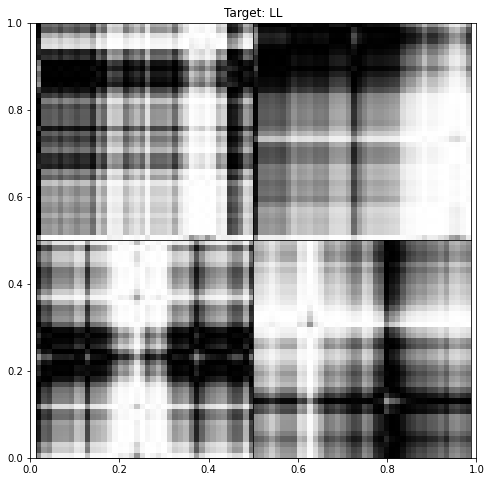

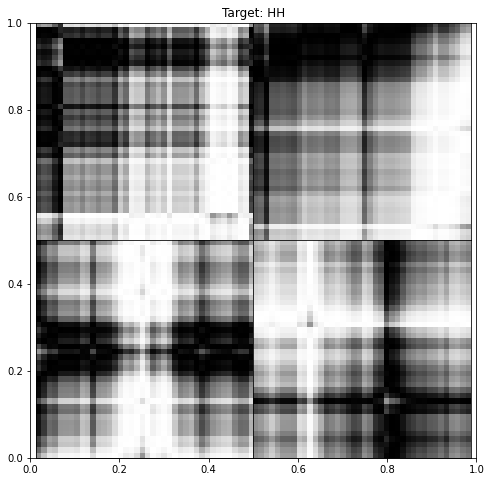

In [33]:
# print 2 last gaf images
images = data_c[0:2].gaf
for img in images:
    plot_gaf_image_matrix(img['img'], img['target'])

# Generate X and y

In [15]:
images_meta = data_c.gaf
X = []
y = []
for img_meta in images_meta:
    X.append(img_meta['img'])
    y.append(img_meta['target'])
X = np.array(X)
y = np.array(y)
X.shape, y.shape

((122, 4, 40, 40), (122,))

In [27]:
y

array(['LL', 'HH', 'LL', 'HH', 'LL', 'HH', 'LL', 'LL', 'HH', 'HH', 'LL',
       'LL', 'HH', 'HH', 'LL', 'LL', 'HH', 'HH', 'HH', 'LL', 'HH', 'HH',
       'LL', 'HH', 'HH', 'LL', 'HH', 'LL', 'HH', 'LL', 'LL', 'HH', 'LL',
       'HH', 'LL', 'HH', 'HH', 'LL', 'LL', 'HH', 'LL', 'HH', 'HH', 'LL',
       'HH', 'LL', 'LL', 'HH', 'HH', 'HH', 'LL', 'HH', 'HH', 'HH', 'LL',
       'HH', 'LL', 'HH', 'LL', 'HH', 'HH', 'HH', 'LL', 'HH', 'LL', 'LL',
       'LL', 'HH', 'HH', 'LL', 'HH', 'HH', 'HH', 'LL', 'HH', 'HH', 'LL',
       'HH', 'HH', 'HH', 'LL', 'HH', 'LL', 'LL', 'HH', 'LL', 'HH', 'HH',
       'HH', 'LL', 'HH', 'LL', 'HH', 'LL', 'HH', 'LL', 'HH', 'HH', 'LL',
       'HH', 'LL', 'HH', 'HH', 'HH', 'HH', 'HH', 'HH', 'LL', 'LL', 'HH',
       'LL', 'HH', 'LL', 'LL', 'LL', 'HH', 'LL', 'LL', 'HH', 'HH', 'LL',
       'HH'], dtype='<U2')